# LAB 9: Stable diffusion customizing

<h4><div style="text-align: right"> Due date: 15:00 Dec 23, 2024.  </div> <br>
<div style="text-align: right"> Please upload your file and final-report at PLATO before the class in the form of [ID_Name_Lab9.ipynb]. </div></h4>



### *Instructions:*
- Write a program implementing a particular algorithm to solve a given problem.   
- <span style="color:red">**Report and discuss your results. Analyze the algorithm, theoretically and empirically.**</span>
- You must write their own answers and codes (<span style="color:red">**if not you will get a F grade**</span>).

<h2><span style="color:blue">[2020556523] [허치영]</span> </h2>

In [1]:
import datetime 
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2024-12-21 20:30:17.558447


### **Required Package**:
- accelerate version: 0.26.1
- datasets==2.16.1
- diffusers version: 0.26.0.dev0
- invisible-watermark version: 0.2.0
- numpy version: 1.26.3
- omegaconf version: 2.3.0
- opencv-python version: 4.9.0.80
- peft==0.7.1
- scipy version: 1.12.0
- torch version: 2.1.2
- torchvision version: 0.16.2
- transformers version: 4.37.0

### **Reference**
- Diffusers Official Document  [homepage](https://huggingface.co/docs/diffusers/main/en/index)  
- Datasets Official Document  [homepage](https://huggingface.co/docs/datasets/index)
- segmind blog [blog](https://blog.segmind.com/prompt-guide-for-stable-diffusion-xl-crafting-textual-descriptions-for-image-generation/)

### **필요 패키지 import**

In [2]:
! pip install -q -U \
    datasets \
    peft \
    diffusers \
    bing-image-downloader

In [3]:
# Standard library imports
import math
import os
import random

# Third-party imports
import numpy as np
import pandas
import glob
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from PIL import Image
from accelerate import Accelerator
from accelerate.logging import get_logger
from datasets import load_dataset
from bing_image_downloader import downloader
from peft import LoraConfig
from peft.utils import get_peft_model_state_dict
from tqdm.auto import tqdm
from torchvision import transforms
from transformers import (
    AutoTokenizer,
    PretrainedConfig,
)

from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    StableDiffusionXLPipeline,
    UNet2DConditionModel,
    StableVideoDiffusionPipeline,
    StableDiffusionPipeline
)
from diffusers.loaders import LoraLoaderMixin
from diffusers.optimization import get_scheduler
from diffusers.training_utils import cast_training_params
from diffusers.utils import (
    make_image_grid,
    convert_state_dict_to_diffusers,
    export_to_video,
    export_to_gif,
)
from diffusers.utils.torch_utils import is_compiled_module

/home/team104/miniconda3/envs/lab9-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Custom Dataset 정의

StableDiffusion과 같은 diffusers에서 지원하는 Diffusion 모델들은 Huggingface에서 지원하는 accelerate, datasets, transformers 와 같은 패키지들과 호환되도록 구현되어 있습니다.
LoRA 학습을 위해서는 Huggingface에서 지원하는 datasets 패키지를 이용하여 Custom Dataset을 정의해야 합니다.


## 1-1. Folder 구조 만들기

In [4]:
custom_dataset_folder_name = "gen_ai_custom_dataset"
if not os.path.exists(custom_dataset_folder_name):
    os.makedirs(custom_dataset_folder_name)
if not os.path.exists(os.path.join(custom_dataset_folder_name, "train")):
    os.makedirs(os.path.join(custom_dataset_folder_name, "train"))
custom_dataset_folder_path = os.path.join(os.getcwd(), custom_dataset_folder_name)

폴더의 구조는 다음과 같이 구성되어 있어야 합니다.
    
    folder/train/dog/golden_retriever.png
    folder/train/cat/maine_coon.png
    folder/test/dog/german_shepherd.png
    folder/test/cat/bengal.png

## 1-2. Image 크롤링

LoRA 학습에 가장 중요한 image들을 모아야합니다.  
원하는 image들을 쉽게 모으기 위해서는
이번 실습에서는 bing 에서 open license image들을 크롤링 하여 사용하였습니다.

In [5]:
query = "8 bit illustration"
downloader.download(
    query,
    limit=100,
    output_dir=custom_dataset_folder_path,
    adult_filter_off=True,
    force_replace=False,
    timeout=60,
    verbose=False,
)


[%] Downloading Images to /home/dlpro24/24-2DLProgramming/huch0/lab9/gen_ai_custom_dataset/8 bit illustration
[Error]Invalid image, not saving https://www.shutterstock.com/image-vector/pixel-art-8-bit-objects-600w-1254656581.jpg

[!] Issue getting: https://www.shutterstock.com/image-vector/pixel-art-8-bit-objects-600w-1254656581.jpg
[!] Error:: Invalid image, not saving https://www.shutterstock.com/image-vector/pixel-art-8-bit-objects-600w-1254656581.jpg

[Error]Invalid image, not saving https://wallpapers.com/images/hd/8-bit-background-00eolrvv0ccowrjf.jpg

[!] Issue getting: https://wallpapers.com/images/hd/8-bit-background-00eolrvv0ccowrjf.jpg
[!] Error:: Invalid image, not saving https://wallpapers.com/images/hd/8-bit-background-00eolrvv0ccowrjf.jpg

[!] Issue getting: https://www.bing.com/th/id/OGC.8c085bc6bcdf9466fc5c8777a0a29564?pid=1.7&amp;rurl=https%3a%2f%2fneocha-content.oss-cn-hongkong.aliyuncs.com%2fwp-content%2fuploads%2fsites%2f2%2f2021%2f09%2fjoojaebum-20.gif&amp;ehk=Azk

In [6]:
# 파일 이름 변경
for idx, item in enumerate(
    os.listdir(
        os.path.join(
            custom_dataset_folder_path,
            query,
        )
    )
):
    format = item.split(".")[-1]
    # idx format 0 -> 00
    idx = str(idx).zfill(2)
    os.rename(
        os.path.join(custom_dataset_folder_path, query, item),
        os.path.join(custom_dataset_folder_path, "train", f"{idx}.{format}"),
    )

# 1-3. Captioning [과제]

LoRA 학습을 위해서는 이미지와 함께 이미지에 대한 설명을 포함하는 caption이 필요합니다. 이를 위해서는 이미지에 대한 caption을 생성해야 합니다. 이미지에 대한 caption을 생성하기 위해서 이미지 캡셔닝 모델 BLIP을 사용하여 Caption을 생성해보세요

In [7]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" # Arrange GPU devices starting from 0 
os.environ["CUDA_VISIBLE_DEVICES"]= "2" # Set the GPU 3 to use

In [8]:
import sys
import platform

print("Python version")
print(sys.version_info)

print("\nOS information")
print(platform.platform())

print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("Available GPUs:", torch.cuda.device_count())

if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(torch.cuda.current_device())}")
    !nvidia-smi
    device = torch.device('cuda')
    torch.cuda.empty_cache()
else:
    device = torch.device('cpu')

print(f"\ndevice={device}")
# os.chdir('/home/dlpro24/24-2DLProgramming/huch0')
print(os.getcwd())

Python version
sys.version_info(major=3, minor=10, micro=16, releaselevel='final', serial=0)

OS information
Linux-5.4.0-200-generic-x86_64-with-glibc2.31
PyTorch version: 2.5.1+cu121
CUDA version: 12.1
Available GPUs: 1
Using GPU: NVIDIA RTX A5000
Sat Dec 21 20:31:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A5000               On  | 00000000:01:00.0 Off |                  Off |

In [9]:
# Device 정의
# device = torch.device("cuda")
# print(torch.cuda.current_device())  # Should print 0 (mapped to GPU 3)
# print(torch.cuda.get_device_name(0)) 
# device = torch.device("mps")

from transformers import BlipProcessor, BlipForConditionalGeneration
# 모델은 "Salesforce/blip-image-captioning-base"로 processor는 "Salesforce/blip-image-captioning-large"로 초기화
# TODO : BlipProcessor 함수를 사용해서 processor를 초기화 해주세요.
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
# TODO : BlipForConditionalGeneration 함수를 사용해서 model을 초기화 해주세요.
model = BlipForConditionalGeneration.from_pretrained(
    "Salesforce/blip-image-captioning-base", torch_dtype=torch.float16
).to(device)

/home/team104/miniconda3/envs/lab9-env/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


모델 정의가 완료되었다면, 예시 이미지로 캡션을 생성해 보세요

In [10]:
# TODO : PIL의 Image, glob, os를 활용하여 test 이미지를 불러와주세요.
test_image = Image.open(next(iter(glob.glob(os.path.join(custom_dataset_folder_path, "train", "87*"))), None))

# Processor를 사용하여 이미지를 모델 입력으로 변환
# TODO : processor 함수를 사용해서 이미지를 모델 입력으로 변환해주세요!
inputs = processor(test_image, return_tensors="pt").to(device, torch.float16)

# Model을 사용하여 이미지 캡션 생성
# TODO : model 함수를 사용하여 이미지 캡션을 생성해주세요!
outputs = model.generate(**inputs, max_new_tokens=50)

# 캡션 출력
# TODO : print 함수를 사용하여 캡션을 출력해주세요!
print(processor.decode(outputs[0], skip_special_tokens=True))

a colorful pixel pattern on a black background


## 1-4. Metadata.csv 작성하기[과제]

이러한 Caption들을 지정된 format에 맞추어 csv 혹은 json 포맷으로 저장해야합니다.  
csv 포맷이라 하면 아래와 같이  

    file_name,additional_feature
    0001.png,This is a first value of a text feature you added to your images
    0002.png,This is a second value of a text feature you added to your images
    0003.png,This is a third value of a text feature you added to your images

json 포맷이라 하면  

    {"file_name": "0001.png", "additional_feature": "This is a first value of a text feature you added to your images"}
    {"file_name": "0002.png", "additional_feature": "This is a second value of a text feature you added to your images"}
    {"file_name": "0003.png", "additional_feature": "This is a third value of a text feature you added to your images"}

와 같이 작성해야합니다.




[과제] 이를 위해 pandas dataframe을 이용하여 caption을 저장하고 metadata.csv 파일을 작성해보세요


In [11]:
# metadata 정의 column으로는 file_name, caption이 들어가야 합니다.
# TODO : pandas의 DataFrame Class를 사용하여 metadata를 정의해주세요. metadata에는 file_name과 caption이 들어가야 합니다.
metadata = pandas.DataFrame(columns=["file_name", "caption"])

In [12]:
for idx, item in enumerate(
    os.listdir(os.path.join(custom_dataset_folder_path, "train"))
):
    format = item.split(".")[-1]
    image_path = os.path.join(custom_dataset_folder_path, "train", item)
    test_image = Image.open(image_path)
    inputs = processor(test_image, return_tensors="pt").to(device, torch.float16) # 여기에 코드를 작성해주세요
    out = model.generate(**inputs, max_new_tokens=50) # 여기에 코드를 작성해주세요
    caption = processor.decode(out[0], skip_special_tokens=True) # 여기에 코드를 작성해주세요
    metadata.loc[idx] = [item, caption]

# 작성히 완료된 metadat는 file_name 순으로 정렬합니다.
metadata = metadata.sort_values(by=["file_name"]).reset_index(drop=True)

# metadata를 csv 파일로 저장합니다.
metadata.to_csv(
    os.path.join(custom_dataset_folder_path, "train", "metadata.csv"), index=False
)


/home/team104/miniconda3/envs/lab9-env/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


최종 폴더구조는 아래와 같이 이루어지게 됩니다
<pre><code>
├── gen_ai_custom_dataset
│   └── train
│   │    └── metadata.csv
│   │    └── 00.jpg
...
</code></pre>

## 1-5. Dataset 정의

위와 같은 과정이 마무리 된다면, 이제 customdataset을 정의할 수 있습니다.

In [13]:
custom_dataset = load_dataset("imagefolder", data_dir=custom_dataset_folder_path)

Generating train split: 100 examples [00:00, 9664.07 examples/s]


## 2. LoRA 학습

#### Prompt Tokenization 을 위한 함수 선언

In [14]:
def tokenize_prompt(tokenizer, prompt):
    text_inputs = tokenizer(
        prompt,
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
)
    text_input_ids = text_inputs.input_ids
    return text_input_ids


def encode_prompt(text_encoders, tokenizers, prompt, text_input_ids_list=None):
    prompt_embeds_list = []

    for i, text_encoder in enumerate(text_encoders):
        if tokenizers is not None:
            tokenizer = tokenizers[i]
            text_input_ids = tokenize_prompt(tokenizer, prompt)
        else:
            assert text_input_ids_list is not None
            try:
                text_input_ids = text_input_ids_list[i]
            except IndexError:
                pass

        prompt_embeds = text_encoder(
            text_input_ids.to(text_encoder.device),
            output_hidden_states=True,
            return_dict=False,
    )

        pooled_prompt_embeds = prompt_embeds[0]
        prompt_embeds = prompt_embeds[-1][-2]
        bs_embed, seq_len, _ = prompt_embeds.shape
        prompt_embeds = prompt_embeds.view(bs_embed, seq_len, -1)
        prompt_embeds_list.append(prompt_embeds)

    prompt_embeds = torch.concat(prompt_embeds_list, dim=-1)
    pooled_prompt_embeds = pooled_prompt_embeds.view(bs_embed, -1)
    return prompt_embeds, pooled_prompt_embeds

def import_model_class_from_model_name_or_path(
    pretrained_model_name_or_path: str, subfolder: str = "text_encoder"
):
    text_encoder_config = PretrainedConfig.from_pretrained(
        pretrained_model_name_or_path, subfolder=subfolder
)
    model_class = text_encoder_config.architectures[0]

    if model_class == "CLIPTextModel":
        from transformers import CLIPTextModel

        return CLIPTextModel(text_encoder_config).from_pretrained(
            pretrained_model_name_or_path, subfolder=subfolder
        )
    elif model_class == "CLIPTextModelWithProjection":
        from transformers import CLIPTextModelWithProjection

        return CLIPTextModelWithProjection(text_encoder_config).from_pretrained(
            pretrained_model_name_or_path, subfolder=subfolder
        )
    else:
        raise ValueError(f"{model_class} is not supported.")

### StableDiffusion을 구성하는 세부 모델들 선언

#### Pretrained Model 및 기타 config 선언
학습에 사용될 pretrained model은 "runwayml/stable-diffusion-v1-5" 을 이용합니다.  
빠른 학습을 위해 Floating Point Precision (부동소수점) 은 16 FP16 을 사용합니다.

In [15]:
MODEL_NAME  = "runwayml/stable-diffusion-v1-5"
VAE_NAME = "stabilityai/sd-vae-ft-mse"
VARIANT = "fp16"

#### [과제] Tokenizer, Text Encoder 선언

Prompt를 사용하기 위해서는 Tokenizer와 Text Encoder를 선언해야합니다.
아래 빈 부분을 작성하여 Tokenizer와 Text Encoder를 선언해보세요

In [16]:
tokenizer_one = AutoTokenizer.from_pretrained(
        # TODO : pretrained_model_name_or_path 값을 정의해주세요.
        pretrained_model_name_or_path = MODEL_NAME,
        # TODO : subfolder 값을 정의해주세요.
        subfolder = "tokenizer",
        # TODO : use_fast 옵션의 값을 정의해주세요.
        use_fast = False,
)
text_encoder_one = import_model_class_from_model_name_or_path(
        # TODO : pretrained_model_name_or_path 값을 정의해주세요.
        pretrained_model_name_or_path = MODEL_NAME,
        # TODO : subfolder 값을 정의해주세요.
        subfolder = "text_encoder",
)

tokenize_two, text_encoder_two = None, None

/home/team104/miniconda3/envs/lab9-env/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.


#### [과제] Noise Scheduler, VAE, UNET 선언

아래 빈 부분을 작성하여 Diffusion 모델을 구성하는 noise scheduler, VAE, UNET을 선언해보세요

In [17]:
noise_scheduler = DDPMScheduler.from_pretrained(
    # TODO : pretrained_model_name_or_path 값을 정의해주세요.
    pretrained_model_name_or_path=MODEL_NAME,
    # TODO : subfolder 값을 정의해주세요.
    subfolder="scheduler"
)

vae = AutoencoderKL.from_pretrained(
    # TODO : pretrained_model_name_or_path 값을 정의해주세요.
    pretrained_model_name_or_path=VAE_NAME,
)

unet = UNet2DConditionModel.from_pretrained(
    # TODO : pretrained_model_name_or_path 값을 정의해주세요.
    pretrained_model_name_or_path=MODEL_NAME,
    # TODO : subfolder 값을 정의해주세요.
    subfolder="unet",
    # TODO : variant 값을 정의해주세요.
    variant=VARIANT,
)

추가된 adapter LoRA 레이어들만 학습 시키기 때문 나머지 함수들은 requires_grad_(False)로 설정해줍니다.

In [18]:
vae.requires_grad_(False)
text_encoder_one.requires_grad_(False)
unet.requires_grad_(False)
print("VAE, Text Encoder, and UNet are frozen.")

VAE, Text Encoder, and UNet are frozen.


### 학습 루프 함수 정의
- 학습 Step 수는 10,000 Step을 권장하나, 학습 소요 시간이 오래 걸릴 경우, Step 수를 줄여 학습을 진행하시길 바랍니다.

In [19]:
seed = 2015
train_batch_size = 2
resolution = 1024
max_train_steps = 10000
checkpointing_steps = 5000
learning_rate = 1e-4
output_dir = "./sd_lora"

# Make sure output_dir exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


In [20]:
logger = get_logger(__name__)

def training_function(dataset, unet, vae, text_encoder_one, text_encoder_two=None):

    # Init Accelerator
    accelerator = Accelerator(mixed_precision=VARIANT)
    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16

    # 세부 모델들 GPU로 올리기, 및 datatype 설정
    unet.to(accelerator.device, dtype=weight_dtype)
    vae.to(accelerator.device, dtype=weight_dtype)
    text_encoder_one.to(accelerator.device, dtype=weight_dtype)
    if text_encoder_two is not None:
        text_encoder_two.to(accelerator.device, dtype=weight_dtype)

    # LoRA config 설정
    # UNet의 Attention Layer에 LoRA weights를 추가
    # Set correct lora layers
    unet_lora_config = LoraConfig(
        r=4, # Dimension of LoRA update Matrices
        lora_alpha=4, # Dimension of LoRA update Matrices
        init_lora_weights="gaussian",
        target_modules=["to_k", "to_q", "to_v", "to_out.0"],
    )
    unet.add_adapter(unet_lora_config)

    # Trainable Parameter (LoRA weights) 만을 FP32로 Upcast
    cast_training_params([unet], dtype=torch.float32)

    # Accelerator에 wrap된 모델을 unwrap하는 내부함수
    def unwrap_model(model):
        model = accelerator.unwrap_model(model)
        model = model._orig_mod if is_compiled_module(model) else model
        return model


    # Custom 된  save & loading hook 함수. LoRA Weight만을 저장하고 불러오는 용도로 사용
    # 실질적으로 accelrator.save_state() 함수 사용을 위해 필요한 함수
    def save_model_hook(models, weights, output_dir):
        if accelerator.is_main_process:
            # there are only two options here. Either are just the unet attn processor layers
            # or there are the unet and text encoder atten layers
            unet_lora_layers_to_save = None
            text_encoder_one_lora_layers_to_save = None
            if text_encoder_two is not None:
                text_encoder_two_lora_layers_to_save = None

            for model in models:
                if isinstance(unwrap_model(model), type(unwrap_model(unet))):
                    unet_lora_layers_to_save = convert_state_dict_to_diffusers(
                        get_peft_model_state_dict(model)
                    )
                elif isinstance(
                    unwrap_model(model), type(unwrap_model(text_encoder_one))
                ):
                    text_encoder_one_lora_layers_to_save = (
                        convert_state_dict_to_diffusers(
                            get_peft_model_state_dict(model)
                        )
                    )
                elif isinstance(
                    unwrap_model(model), type(unwrap_model(text_encoder_two))
                ):
                    text_encoder_two_lora_layers_to_save = (
                        convert_state_dict_to_diffusers(
                            get_peft_model_state_dict(model)
                        )
                    )
                else:
                    raise ValueError(f"unexpected save model: {model.__class__}")

                # make sure to pop weight so that corresponding model is not saved again
                if weights:
                    weights.pop()

            if text_encoder_two is not None:
                StableDiffusionXLPipeline.save_lora_weights(
                    output_dir,
                    unet_lora_layers=unet_lora_layers_to_save,
                    text_encoder_lora_layers=text_encoder_one_lora_layers_to_save,
                    text_encoder_2_lora_layers=text_encoder_two_lora_layers_to_save,
                )
            else:
                StableDiffusionPipeline.save_lora_weights(
                    output_dir,
                    unet_lora_layers=unet_lora_layers_to_save,
                    text_encoder_lora_layers=text_encoder_one_lora_layers_to_save,
                )

    def load_model_hook(models, input_dir):
        unet_ = None
        text_encoder_one_ = None
        text_encoder_two_ = None

        while len(models) > 0:
            model = models.pop()

            if isinstance(model, type(unwrap_model(unet))):
                unet_ = model
            elif isinstance(model, type(unwrap_model(text_encoder_one))):
                text_encoder_one_ = model
            elif isinstance(model, type(unwrap_model(text_encoder_two))):
                text_encoder_two_ = model
            else:
                raise ValueError(f"unexpected save model: {model.__class__}")

        lora_state_dict, network_alphas = LoraLoaderMixin.lora_state_dict(input_dir)
        LoraLoaderMixin.load_lora_into_unet(
            lora_state_dict, network_alphas=network_alphas, unet=unet_
        )

        text_encoder_state_dict = {
            k: v for k, v in lora_state_dict.items() if "text_encoder." in k
        }
        LoraLoaderMixin.load_lora_into_text_encoder(
            text_encoder_state_dict,
            network_alphas=network_alphas,
            text_encoder=text_encoder_one_,
        )
        if text_encoder_two_ is not None:
            text_encoder_2_state_dict = {
                k: v for k, v in lora_state_dict.items() if "text_encoder_2." in k
            }
            LoraLoaderMixin.load_lora_into_text_encoder(
                text_encoder_2_state_dict,
                network_alphas = network_alphas,
                text_encoder = text_encoder_two_,
            )

    accelerator.register_save_state_pre_hook(save_model_hook)
    accelerator.register_load_state_pre_hook(load_model_hook)

    # Optimizer 설정
    optimizer_class = torch.optim.AdamW
    # Optimizer creation
    params_to_optimize = list(filter(lambda p: p.requires_grad, unet.parameters()))
    optimizer = optimizer_class(
        params_to_optimize,
        lr=learning_rate*train_batch_size,
        betas = (0.9, 0.999),
        weight_decay = 1e-2,
        eps = 1e-08,
    )

    # Preprocessing the datasets
    # 먼저 데이터셋의 Column 구분 (Image, Caption)
    column_names = dataset["train"].column_names
    image_column = column_names[0]
    caption_column = column_names[1]

   # Captipon 들을 두가지 Text Tokenizer로 Tokenize 하는 내부함수 정의
    def tokenize_captions(examples, is_train=True,):
        captions = []
        for caption in examples[caption_column]:
            if isinstance(caption, str):
                captions.append(caption)
            elif isinstance(caption, (list, np.ndarray)):
                # take a random caption if there are multiple
                captions.append(random.choice(caption) if is_train else caption[0])
            else:
                raise ValueError(
                    f"Caption column `{caption_column}` should contain either strings or lists of strings."
                )
        tokens_one = tokenize_prompt(tokenizer_one, captions)
        if text_encoder_two is not None:
            tokens_two = tokenize_prompt(tokenizer_two, captions)
        else:
            tokens_two = None
        return tokens_one, tokens_two

    # Image 를 전처리 하는 부분 정의
    train_resize = transforms.Resize(resolution, interpolation=transforms.InterpolationMode.BILINEAR)
    train_crop = transforms.CenterCrop(resolution)
    train_flip = transforms.RandomHorizontalFlip(p=1.0)
    train_transforms = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ]
    )

    # Image 와 Caption preprocessing 을 위한 종합 내부함수정의
    def preprocess_train(examples):
        images = [image.convert("RGB") for image in examples[image_column]]

        # image aug
        original_sizes = []
        all_images = []
        crop_top_lefts = []
        for image in images:
            original_sizes.append((image.height, image.width))
            image = train_resize(image)
            if random.random() < 0.5:# flip
                image = train_flip(image)
            y1 = max(0, int(round((image.height - resolution) / 2.0)))
            x1 = max(0, int(round((image.width - resolution) / 2.0)))
            image = train_crop(image)
            crop_top_left = (y1, x1)
            crop_top_lefts.append(crop_top_left)
            image = train_transforms(image)
            all_images.append(image)

        examples["original_sizes"] = original_sizes
        examples["crop_top_lefts"] = crop_top_lefts
        examples["pixel_values"] = all_images
        tokens_one, tokens_two = tokenize_captions(examples)
        examples["input_ids_one"] = tokens_one
        if text_encoder_two is not None:
            examples["input_ids_two"] = tokens_two
        return examples

    # Training Dataset 생성
    train_dataset = dataset["train"].with_transform(preprocess_train)

    # DataLoader 생성
    def collate_fn(examples):
        pixel_values = torch.stack([example["pixel_values"] for example in examples])
        pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()
        original_sizes = [example["original_sizes"] for example in examples]
        crop_top_lefts = [example["crop_top_lefts"] for example in examples]
        input_ids_one = torch.stack([example["input_ids_one"] for example in examples])
        if text_encoder_two is not None:
            input_ids_two = torch.stack([example["input_ids_two"] for example in examples])
            return {
                "pixel_values": pixel_values,
                "input_ids_one": input_ids_one,
                "input_ids_two": input_ids_two,
                "original_sizes": original_sizes,
                "crop_top_lefts": crop_top_lefts,
            }
        else:
            return {
                "pixel_values": pixel_values,
                "input_ids_one": input_ids_one,
                "original_sizes": original_sizes,
                "crop_top_lefts": crop_top_lefts,
            }
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        shuffle = True,
        collate_fn = collate_fn,
        batch_size = train_batch_size,
        num_workers = 0,
    )

    lr_scheduler = get_scheduler(
        'cosine',
        optimizer=optimizer,
        num_warmup_steps = 500 * 1,
        num_training_steps = max_train_steps *1,
    )

    # Prepare with  accelerator
    unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(unet, optimizer, train_dataloader, lr_scheduler)


    # Training 시작 전 기본 세팅
    num_train_epochs = math.ceil(max_train_steps / len(train_dataset))
    total_batch_size = train_batch_size * accelerator.num_processes
    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Num Epochs = {num_train_epochs}")
    logger.info(f"  Instantaneous batch size per device = {train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Total optimization steps = {max_train_steps}")
    global_step = 0
    first_epoch = 0
    initial_global_step = 0

    progress_bar = tqdm(
        range(0, max_train_steps),
        initial = initial_global_step,
        desc="Steps",
        # Only show the progress bar once on each machine.
        disable = not accelerator.is_local_main_process,
    )

    # Training Loop 시작
    for epoch in range(first_epoch, num_train_epochs):
        unet.train()
        train_loss = 0.0
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(unet):
                # Convert images to latent space
                pixel_values = batch["pixel_values"].to(dtype=weight_dtype)
                model_input = vae.encode(pixel_values).latent_dist.sample()
                model_input = model_input * vae.config.scaling_factor

                # Sample noise that we'll add to the latents
                noise = torch.randn_like(model_input)

                bsz = model_input.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(
                    0,
                    noise_scheduler.config.num_train_timesteps,
                    (bsz,),
                    device=model_input.device,
                )
                timesteps = timesteps.long()

                # Add noise to the model input according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_model_input = noise_scheduler.add_noise(model_input, noise, timesteps)

                # time ids
                def compute_time_ids(original_size, crops_coords_top_left):
                    # Adapted from pipeline.StableDiffusionXLPipeline._get_add_time_ids
                    target_size = (resolution, resolution)
                    add_time_ids = list(original_size + crops_coords_top_left + target_size)
                    add_time_ids = torch.tensor([add_time_ids])
                    add_time_ids = add_time_ids.to(accelerator.device, dtype=weight_dtype)
                    return add_time_ids

                add_time_ids = torch.cat(
                    [
                        compute_time_ids(s, c)
                        for s, c in zip(
                            batch["original_sizes"], batch["crop_top_lefts"]
                        )
                    ]
                )

                # Predict the noise residual
                unet_added_conditions = {"time_ids": add_time_ids}

                if text_encoder_two is not None:
                    text_input_ids_list = [
                        batch["input_ids_one"],
                        batch["input_ids_two"],
                    ]
                    prompt_embeds, pooled_prompt_embeds = encode_prompt(
                        text_encoders=[text_encoder_one, text_encoder_two],
                        tokenizers=None,
                        prompt=None,
                        text_input_ids_list=text_input_ids_list,
                    )
                else:
                    text_input_ids_list = [batch["input_ids_one"]]

                    prompt_embeds, pooled_prompt_embeds = encode_prompt(
                        text_encoders=[text_encoder_one],
                        tokenizers=None,
                        prompt=None,
                        text_input_ids_list=text_input_ids_list,
                    )
                unet_added_conditions.update({"text_embeds": pooled_prompt_embeds})
                model_pred = unet(
                    noisy_model_input,
                    timesteps,
                    prompt_embeds,
                    added_cond_kwargs=unet_added_conditions,
                    return_dict=False,
                )[0]


                if noise_scheduler.config.prediction_type == "epsilon":
                    target = noise
                elif noise_scheduler.config.prediction_type == "v_prediction":
                    target = noise_scheduler.get_velocity(model_input, noise, timesteps)
                else:
                    raise ValueError(
                        f"Unknown prediction type {noise_scheduler.config.prediction_type}"
                    )

                loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")


                # Gather the losses across all processes for logging (if we use distributed training).
                avg_loss = accelerator.gather(loss.repeat(train_batch_size)).mean()
                train_loss += avg_loss.item()

                # Backpropagate
                accelerator.backward(loss)
                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(params_to_optimize, 1)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1
                accelerator.log({"train_loss": train_loss}, step=global_step)
                train_loss = 0.0

                if accelerator.is_main_process:
                    if global_step % checkpointing_steps == 0:
                        save_path = os.path.join(
                            output_dir, f"checkpoint-{global_step}"
                        )
                        accelerator.save_state(save_path)
                        logger.info(f"Saved state to {save_path}")

            logs = {
                "step_loss": loss.detach().item(),
                "lr": lr_scheduler.get_last_lr()[0],
            }
            progress_bar.set_postfix(**logs)

            if global_step >= max_train_steps:
                break
    # Training 종료
    # Save the lora layers
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        unet = unwrap_model(unet)
        unet_lora_state_dict = convert_state_dict_to_diffusers(get_peft_model_state_dict(unet))
        StableDiffusionXLPipeline.save_lora_weights(
            save_directory=output_dir,
            unet_lora_layers=unet_lora_state_dict,
        )
        del unet
        torch.cuda.empty_cache()

In [21]:
import accelerate

accelerate.notebook_launcher(training_function, args=(custom_dataset, unet, vae, text_encoder_one), num_processes=0)

/home/team104/miniconda3/envs/lab9-env/lib/python3.10/site-packages/accelerate/accelerator.py:449: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Launching training on one GPU.


Steps:   0%|          | 28/10000 [00:28<2:48:01,  1.01s/it, lr=1.12e-5, step_loss=0.477]/home/team104/miniconda3/envs/lab9-env/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Steps:  50%|█████     | 5000/10000 [1:27:40<1:27:40,  1.05s/it, lr=0.000108, step_loss=0.0107]  


## [과제] Load 학습된 LoRA

학습된 LoRA 모델을 불러와서 inference를 수행해보세요
이를 위해 pipeline을 정의하고, 학습한 lora weight를 불러와 이미지를 생성해보세요

In [44]:
pipeline = StableDiffusionPipeline.from_pretrained(
    # TODO : pretrained_model_name_or_path 값을 정의해주세요.
    pretrained_model_name_or_path=MODEL_NAME,
    # TODO : torch_dtype 값을 정의해주세요.
    torch_dtype=torch.float16,
    # TODO : variant 값을 정의해주세요.
    variant=VARIANT,
    # TODO : use_safetensors 옵션을 정의해주세요.
    use_safetensors=True,
)
pipeline = pipeline.to(device)
print("pipeline loaded")

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  9.71it/s]


pipeline loaded


In [45]:
# "./sd_lora_custom"에 저장된 LoRA weights를 불러와보세요.
# TODO : pipline class 내부 함수인 load_lora_weights를 사용하여 "./sd_lora_custom"에 저장된 LoRA weights를 불러와보세요.
pipeline.load_lora_weights("./sd_lora")

100%|██████████| 50/50 [00:06<00:00,  8.06it/s]


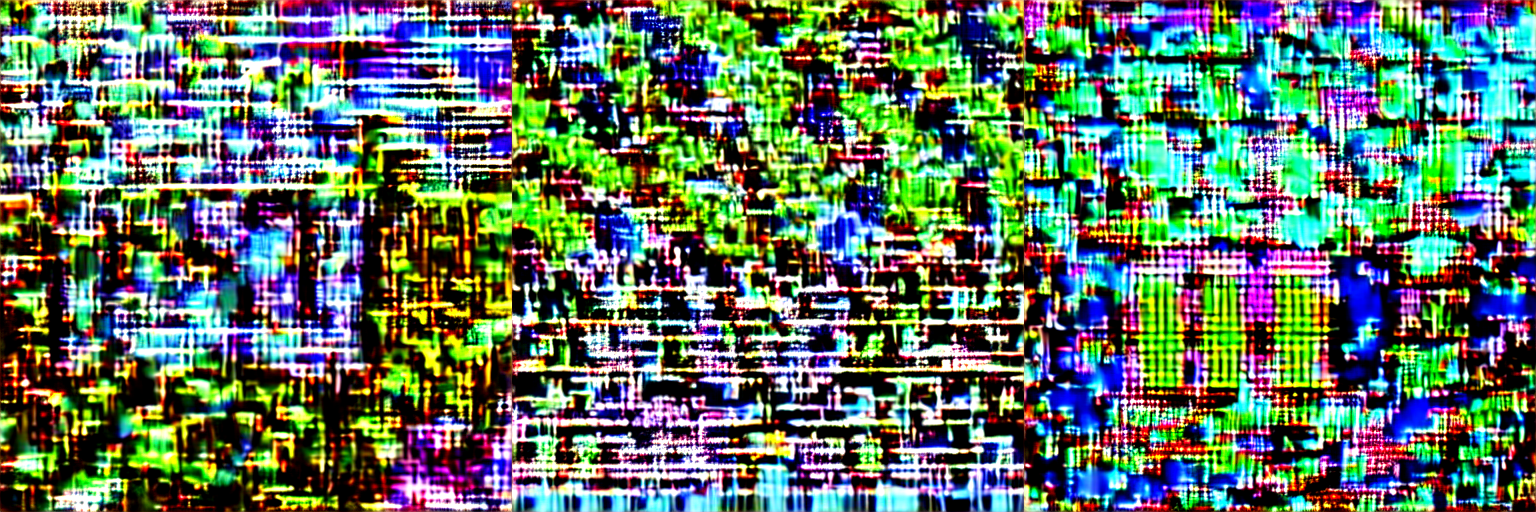

In [46]:
inference_prompt = "8bit illustration of city view"
pipeline.safety_checker = None
images = pipeline(inference_prompt, num_images_per_prompt=3).images
image_grid = make_image_grid(images, rows=1, cols=3)
image_grid.save("image_grid.png")
image_grid
